In [67]:
using Plots
using LaTeXStrings
target(x::Float64) = (x^3-15*x^2+7*x+1)/10
target_to_test(x::Float64) = 1/3*x^3-x^2-3*x

global Lf_max=0
function df(f, points)
    result = []
    for idx in 2:length(points)-1
        push!(result, (f(points[idx+1]) - f(points[idx-1]))/(points[idx+1]-points[idx-1]))
        global Lf_max = max(Lf_max, max(abs(result[end])))
    end
    return result
end

function ddf(f, points)
    result = []
    for idx in 2:length(points)-1
        push!(result, (f(points[idx+1]) - 2 * f(points[idx]) + f(points[idx-1]))/(points[idx+1]-points[idx])^2)
    end
    return result
end

function ddf_with_points(f, points)
    result = []
    for idx in 2:length(points)-1
        push!(result, (f(points[idx+1]) - 2 * f(points[idx]) + f(points[idx-1]))/(points[idx+1]-points[idx])^2)
    end
    return result, points[2:length(points)-1]
end

function get_fib(n)
    sqrt5 = sqrt(5)
    trunc(Int, (1 / sqrt5) * (((1 + sqrt5) / 2)^n - ((1  - sqrt5) / 2)^n))
end

function is_unimodal_df(f, a, b, N=1000)
    deriv = df(f, range(a, b, N))
    last_deriv = deriv[1]
    for current_deriv in deriv[2:length(deriv)-1]
        if current_deriv <= last_deriv
            return false
        end
    end
    return true
end

function is_unimodal_ddf(f, a, b, N=1000)
    for current_deriv in ddf(f, range(a, b, N))
        if current_deriv < 0
            return false
        end
    end
    return true
end

function search_unimodal_segment(f, a, b, N=1000)
    deriv, points = ddf_with_points(f, range(a, b, N))
    interval_start, interval_end = nothing, nothing
    result_start, result_end = nothing, nothing
    for (second_deriv, point) in zip(deriv, points)
        if second_deriv < 0
            if interval_start != nothing
                if (interval_end - interval_start) > (result_end - result_start)
                    result_start, result_end = interval_start, interval_end
                end
                interval_start = nothing
                interval_end = nothing
            end
        elseif second_deriv > 0
            if interval_start == nothing
                interval_start = point
            end
            interval_end = point
        end
    end
    if result_end == nothing || result_start == nothing
        return interval_start, interval_end    
    end
    if (interval_end - interval_start) > (result_end - result_start)
        result_start, result_end = interval_start, interval_end
    end
    return result_start, result_end
end

search_unimodal_segment (generic function with 2 methods)

In [38]:
function function_min_iter(f, start, stop, n)
    dots = []
    step = (stop - start) / n
    min_value = f(start)
    min_point = start
    for i in 1:n
        x = start + i * step
        append!(dots, x)
        if f(x) < min_value
            min_value = f(x)
            min_point = x
        end
    end
    error = (stop - start)/n
    return min_point, dots, error, n
end

function function_min_dyhotomy(f, a, b, eps=1.e-6)
    dots = []
    iter = 0
    while abs(b - a) > eps
        iter += 1
        mid = (a + b) / 2
        f1 = f(mid - eps)
        f2 = f(mid + eps)
        append!(dots, mid - eps)
        append!(dots, mid + eps)
        if f1 < f2
            b = mid
        else
            a = mid
        end
    end
    error = Lf_max * eps / 2
    return (a + b) / 2, dots, error, iter
end

function function_min_golden(f, start, stop, eps=1.e-6)
    phi = (sqrt(5.0) - 1) / 2
    dots = []
    iter = 0
    while abs(stop - start) > eps
        iter += 1
        c = stop - (stop - start) * phi
        d = start + (stop - start) * phi
        append!(dots, c)
        append!(dots, d)
        if f(c) < f(d)
            stop = d
        else
            start = c
        end
    end
    error = Lf_max * phi * eps
    return (start + stop) / 2, dots, error, iter
end

function function_min_fib(f, a, b, n, eps=1.e-6)
    x1 = a + (get_fib(n) / get_fib(n + 2)) * (b - a)
    x2 = a + b - x1
    y1 = f(x1)
    y2 = f(x2)
    dots = []
    iter = 0
    while abs(b - a) > eps
        iter += 1
        if y1 <= y2
            b = x2
            x2 = x1
            x1 = a + b - x1
            y2 = y1
            y1 = f(x1)
        else
            a = x1
            x1 = x2
            x2 = a + b - x2
            y1 = y2
            y2 = f(x2)
        end

        append!(dots, (a + b) / 2)
    end
    error = Lf_max * eps
    return (a + b) / 2, dots, error, iter
end

function_min_fib (generic function with 2 methods)

In [75]:
target_start, target_end = search_unimodal_segment(target, -5, 50)
println("Is unimodal at ($(target_start), $(target_end)): $(is_unimodal_df(target, target_start, target_end))")
iterate_min, iterate_div_plot, iterate_error, iterate_iter = function_min_iter(target, target_start, target_end, 1000)
dyhotomy_min, dyhotomy_div_plot, dyhotomy_error, dyhotomy_iter = function_min_dyhotomy(target, target_start, target_end)
golden_min, golden_div_plot, golden_error, golden_iter = function_min_golden(target, target_start, target_end)
fib_min, fib_div_plot, fib_error, fib_iter = function_min_fib(target, target_start, target_end, 20)
println("Minimums: $(iterate_min), $(dyhotomy_min), $(golden_min), $(fib_min)")

Is unimodal at (5.02002002002002, 49.94494494494494): true
Minimums: 9.782062062062062, 9.760952088329287, 9.760952017111975, 9.758304688260814


In [41]:
x = range(-1, 1, length=1000)
function plot_method(points, error, iterations)
    plot(range(-1, 1.5, length=1000), target.(range(-1, 1.5, length=1000)), label=L"\frac{(x^3-15*x^2+7*x+1)}{10}", ylim=(-6, 6), xlim=(-3, 3))
    plot!(points, target.(points), seriestype=:scatter, mc=:blue)
    plot!([], [], labels="error=$(round(error, digits=10))")
    plot!([], [], labels="iterations=$(iterations)")
end


plot_method (generic function with 2 methods)

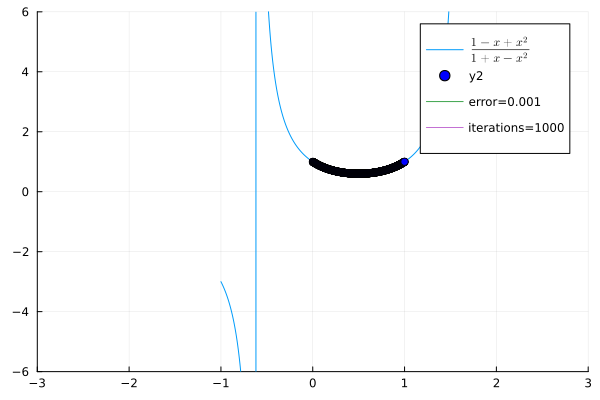

In [42]:
plot_method(iterate_div_plot, iterate_error, iterate_iter)

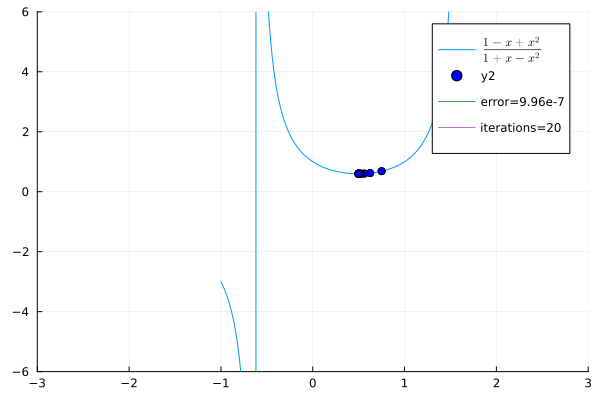

In [43]:
plot_method(dyhotomy_div_plot, dyhotomy_error, dyhotomy_iter)

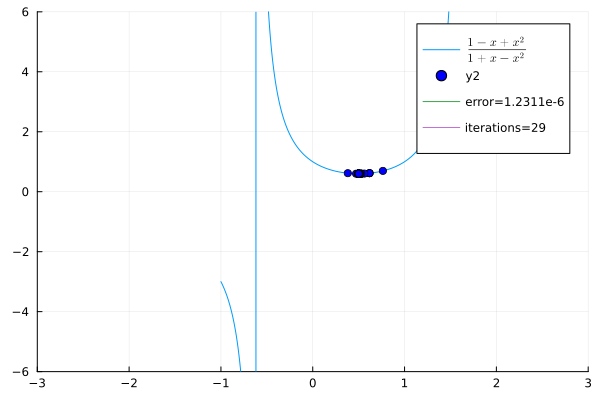

In [44]:
plot_method(golden_div_plot, golden_error, golden_iter)

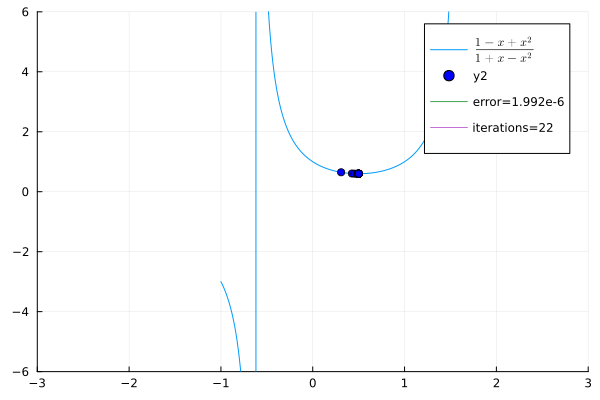

In [45]:
plot_method(fib_div_plot, fib_error, fib_iter)

In [47]:
is_unimodal_df(target, 0, 1)

true

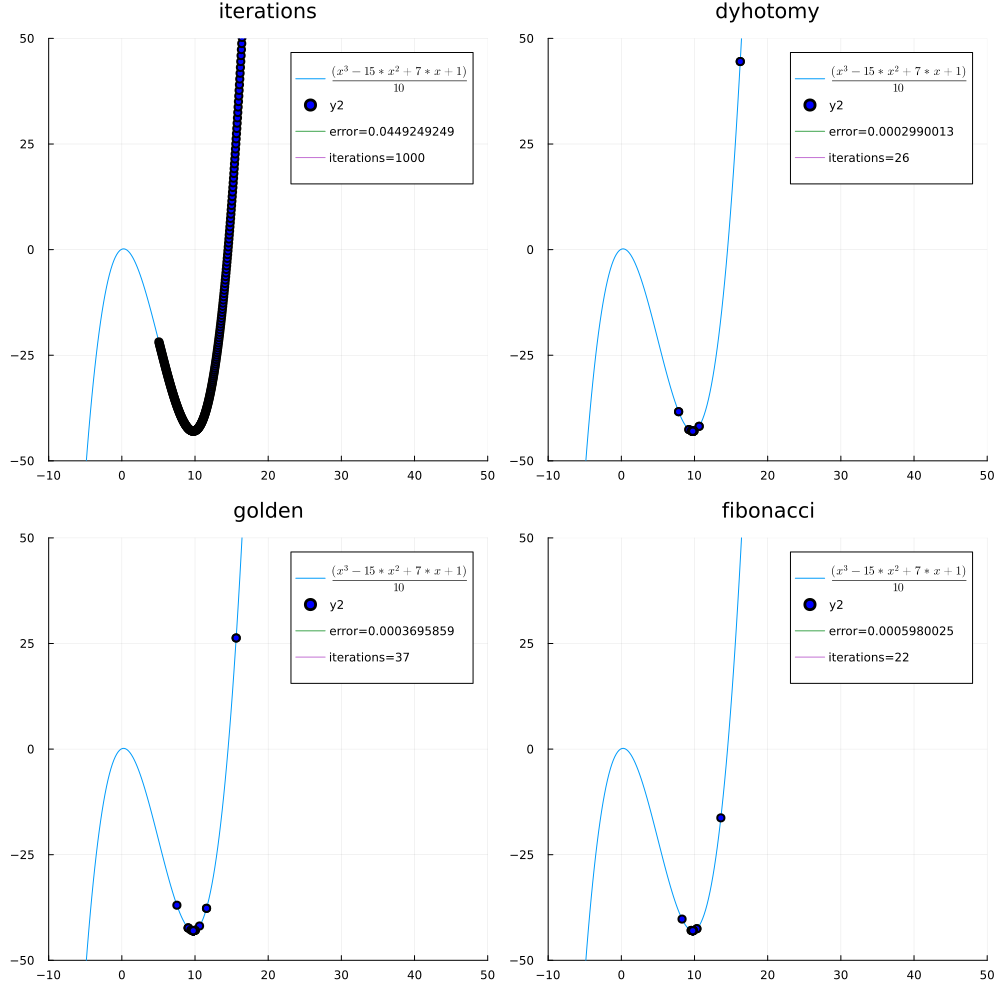

In [77]:
function plot_method(points, error, iterations, title)
    plt = plot(size=(1000, 1000), title=title)
    plot!(plt, range(-100, 100, length=1000), target.(range(-100, 100, length=1000)), label=L"\frac{(x^3-15*x^2+7*x+1)}{10}", ylim=(-50, 50), xlim=(-10, 50))
    plot!(plt, points, target.(points), seriestype=:scatter, mc=:blue)
    plot!(plt, [], [], labels="error=$(round(error, digits=10))")
    plot!(plt, [], [], labels="iterations=$(iterations)")
    return plt
end

p1 = plot_method(iterate_div_plot, iterate_error, iterate_iter, "iterations")
p2 = plot_method(dyhotomy_div_plot, dyhotomy_error, dyhotomy_iter, "dyhotomy")
p3 = plot_method(golden_div_plot, golden_error, golden_iter, "golden")
p4 = plot_method(fib_div_plot, fib_error, fib_iter, "fibonacci")
plot(p1, p2, p3, p4)

In [68]:
search_unimodal_segment(target_to_test, -10, 10)

(1.011011011011011, 9.97997997997998)